In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px

# Load dataset
df = pd.read_csv("daily_food_nutrition_dataset.csv")
df.head()


NameError: name 'read_csv' is not defined

In [17]:
df['Date'] = pd.to_datetime(df['Date'])  # Ensure date format
df.dropna(inplace=True)  # Remove missing values
df.info()  # Confirm data structure


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               10000 non-null  datetime64[ns]
 1   User_ID            10000 non-null  int64         
 2   Food_Item          10000 non-null  object        
 3   Category           10000 non-null  object        
 4   Calories (kcal)    10000 non-null  int64         
 5   Protein (g)        10000 non-null  float64       
 6   Carbohydrates (g)  10000 non-null  float64       
 7   Fat (g)            10000 non-null  float64       
 8   Fiber (g)          10000 non-null  float64       
 9   Sugars (g)         10000 non-null  float64       
 10  Sodium (mg)        10000 non-null  int64         
 11  Cholesterol (mg)   10000 non-null  int64         
 12  Meal_Type          10000 non-null  object        
 13  Water_Intake (ml)  10000 non-null  int64         
dtypes: date

<ipython-input-18-c713e7d6232d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Meal_Type', palette='Set2')


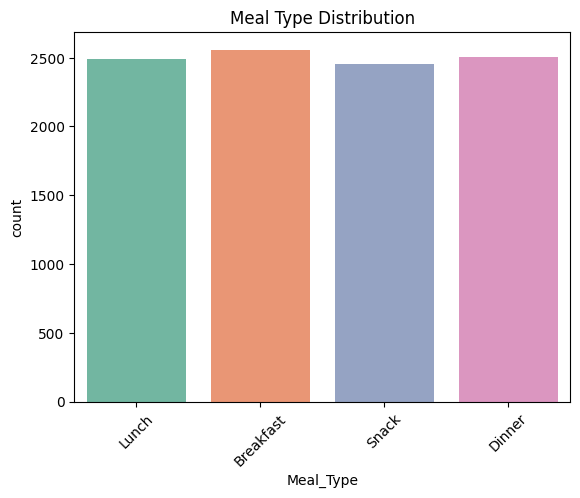

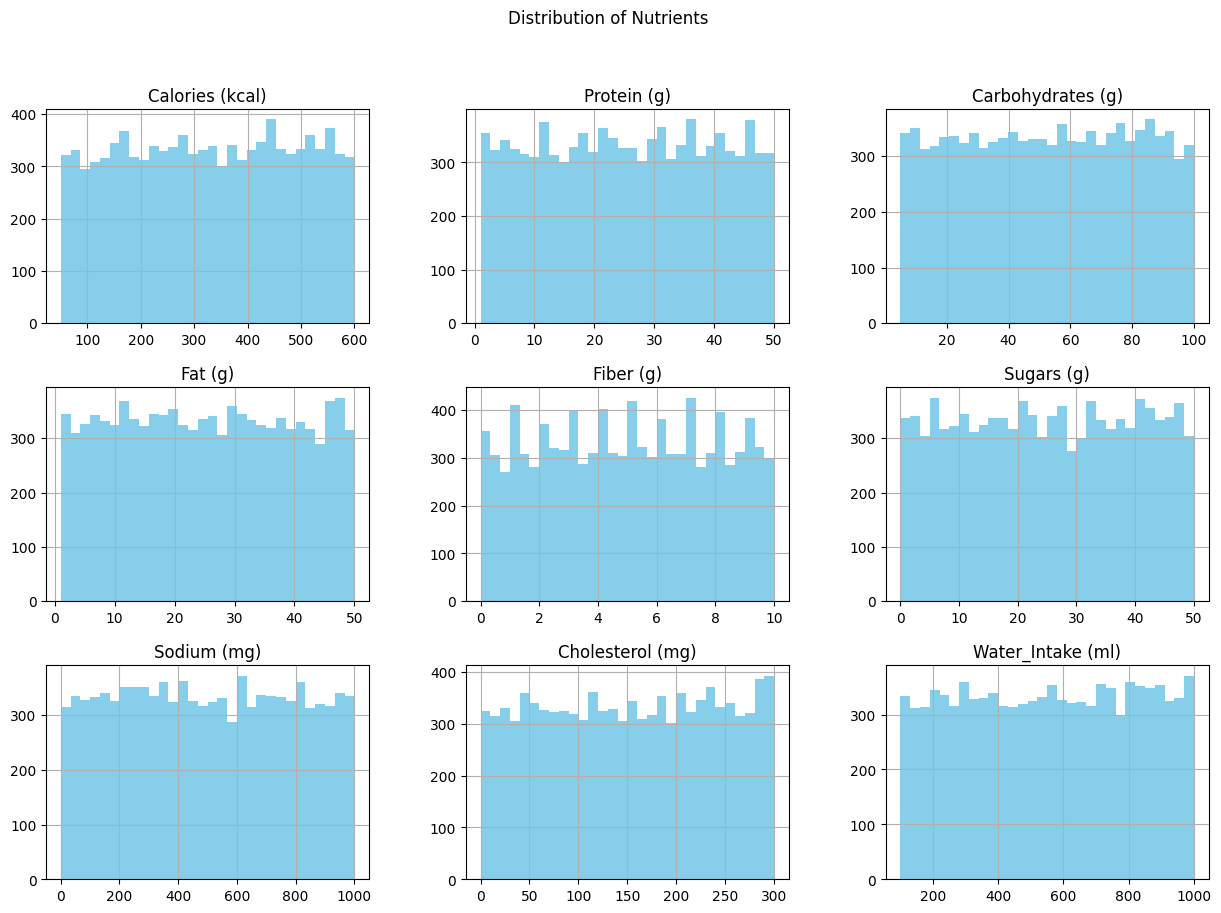

In [18]:
# 3.1 Meal Type Distribution
sns.countplot(data=df, x='Meal_Type', palette='Set2')
plt.title("Meal Type Distribution")
plt.xticks(rotation=45)
plt.show()

# 3.2 Nutrient Distributions
nutrients = ['Calories (kcal)', 'Protein (g)', 'Carbohydrates (g)', 'Fat (g)',
             'Fiber (g)', 'Sugars (g)', 'Sodium (mg)', 'Cholesterol (mg)', 'Water_Intake (ml)']
df[nutrients].hist(bins=30, figsize=(15, 10), color='skyblue')
plt.suptitle("Distribution of Nutrients")
plt.show()


In [19]:
daily_nutrition = df.groupby(['User_ID', 'Date'])[nutrients].sum().reset_index()


In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(daily_nutrition[nutrients])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
daily_nutrition['Health_Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster Characteristics
print(daily_nutrition.groupby('Health_Cluster')[nutrients].mean().round(1))



                Calories (kcal)  Protein (g)  Carbohydrates (g)  Fat (g)  \
Health_Cluster                                                             
0                         401.9         29.2               63.5     30.5   
1                         283.5         24.8               44.7     22.7   
2                         323.4         24.4               53.2     25.0   

                Fiber (g)  Sugars (g)  Sodium (mg)  Cholesterol (mg)  \
Health_Cluster                                                         
0                     5.5        34.2        606.7             200.2   
1                     4.9        19.9        442.1             220.6   
2                     4.8        23.9        484.9              66.8   

                Water_Intake (ml)  
Health_Cluster                     
0                           728.2  
1                           450.5  
2                           538.4  


<ipython-input-21-661a78cc284f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily_nutrition, x='Health_Cluster', y='Calories (kcal)', palette='coolwarm')


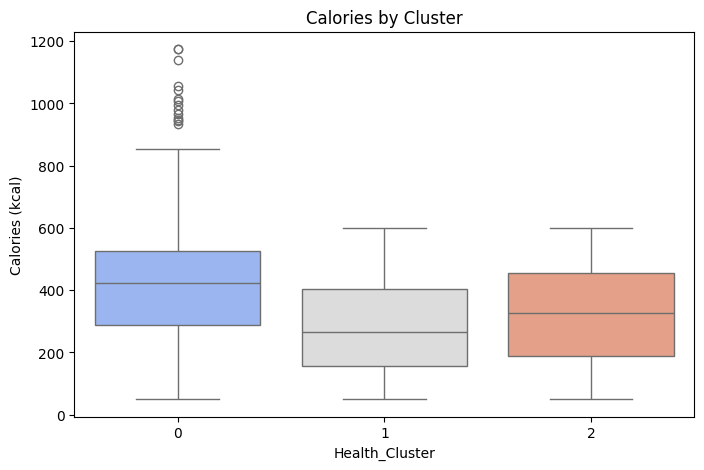

In [21]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=daily_nutrition, x='Health_Cluster', y='Calories (kcal)', palette='coolwarm')
plt.title("Calories by Cluster")
plt.show()


In [22]:
def compute_risk(row):
    score = 0
    if row['Calories (kcal)'] > 3000: score += 2
    if row['Sugars (g)'] > 50: score += 2
    if row['Cholesterol (mg)'] > 300: score += 2
    if row['Sodium (mg)'] > 2300: score += 2
    if row['Fiber (g)'] < 15: score += 2
    return score

daily_nutrition['Health_Risk_Score'] = daily_nutrition.apply(compute_risk, axis=1)


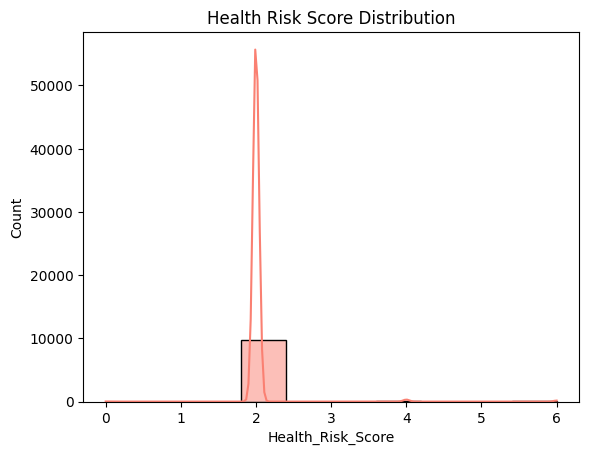

In [23]:
sns.histplot(data=daily_nutrition, x='Health_Risk_Score', bins=10, kde=True, color='salmon')
plt.title("Health Risk Score Distribution")
plt.show()


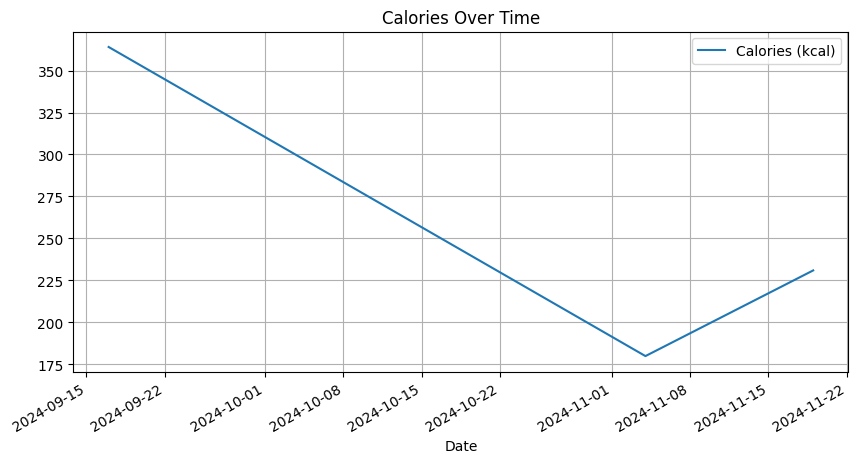

In [24]:
# Pick a sample user
sample_user = daily_nutrition[daily_nutrition['User_ID'] == daily_nutrition['User_ID'].iloc[0]]
sample_user.plot(x='Date', y='Calories (kcal)', title='Calories Over Time', figsize=(10, 5))
plt.grid()
plt.show()


In [26]:
macro_avg = df[['Protein (g)', 'Carbohydrates (g)', 'Fat (g)']].mean()

fig = go.Figure(data=go.Scatterpolar(
  r=macro_avg,
  theta=['Protein', 'Carbohydrates', 'Fat'],
  fill='toself',
  name='Average Macros'
))
fig.update_layout(
  polar=dict(radialaxis=dict(visible=True)),
  title="Macro Nutrient Balance Radar"
)
fig.show()


In [27]:
def health_tip(score):
    if score >= 8:
        return "High Risk: Reduce sugar, fat, and cholesterol intake."
    elif score >= 5:
        return "Moderate Risk: Monitor sodium and sugar levels."
    else:
        return "Healthy: Keep it up!"

daily_nutrition['Health_Advice'] = daily_nutrition['Health_Risk_Score'].apply(health_tip)
daily_nutrition[['User_ID', 'Date', 'Health_Risk_Score', 'Health_Advice']].head()


,User_ID,Date,Health_Risk_Score,Health_Advice
0,1,2024-09-17,2,Healthy: Keep it up!
1,1,2024-11-04,2,Healthy: Keep it up!
2,1,2024-11-19,2,Healthy: Keep it up!
3,2,2024-04-10,2,Healthy: Keep it up!
4,2,2024-05-08,2,Healthy: Keep it up!
